In [1]:
# test: any migrations in merge commits?
# 12f23eddde <rzhe@pku.edu.cn> - Apr 28 2021

In [36]:
import sys
import os
import pandas as pd
import numpy as np

In [37]:
# read credentials from config
import os
import configparser

config = configparser.ConfigParser()
if (os.path.exists('config.ini')):
    config.read('config.ini')
else:
    raise Exception('config.ini not found')
    
MONGO_URL='mongodb://' + config['MongoDB']['addr']
MONGO_URL

'mongodb://127.0.0.1:27017'

In [41]:
# 并行框架
from tqdm.auto import tqdm
from pathos.pools import ProcessPool
import time

def parallel(func, *args, core_num=8, progress_bar=tqdm, return_df=True):
    pool = ProcessPool(core_num)
    try:
        start = time.time()
        # imap方法
        with progress_bar(total=len(args[0]), desc="计算进度") as t:  # 进度条设置
            if return_df:  # return dataframe
                r = pd.DataFrame()
                for i in pool.imap(func, *args):
                    r = r.append(i, ignore_index=True)
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
                return r
            else:  # return nothing
                for i in pool.imap(func, *args):
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state

In [42]:
CACHE_DIR = "cache/"
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
import pymongo
# establish db connection
db = pymongo.MongoClient(MONGO_URL).migration_helper

In [43]:
class WOCException(Exception):
    pass

In [44]:
import pandas as pd
df_projects = pd.read_csv('cache/projects.csv', low_memory=False)
df_projects

,_id,hostType,nameWithOwner,description,fork,forkSourceNameWithOwner,createdTimestamp,updatedTimestamp,lastPushedTimestamp,homepageURL,...,contributorsCount,readmeFilename,changeLogFilename,contributingGuidelinesFilename,licenseFilename,codeOfConductFilename,_class,pomFilesCount,pomFileModifyingCommitsCount,commitsCount
0,36668790,GitHub,Snailclimb/JavaGuide,���Java������+��������������� ����������������...,False,NaN,2018-05-07 13:27:00 UTC,2019-12-31 02:06:55 UTC,2019-12-30 01:20:45 UTC,https://javaguide.cn/,...,7,README.md,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,2,3,1524
1,844503,GitHub,iluwatar/java-design-patterns,Design patterns implemented in Java,False,NaN,2014-08-09 16:45:18 UTC,2019-12-28 19:51:58 UTC,2019-12-28 18:46:47 UTC,https://java-design-patterns.com,...,50,README.md,NaN,NaN,LICENSE.md,NaN,edu.pku.migrationhelper.data.LioRepository,149,248,3572
2,167096,GitHub,elastic/elasticsearch,"Open Source, Distributed, RESTful Search Engine",False,NaN,2010-02-08 13:20:56 UTC,2019-12-28 10:52:24 UTC,2019-12-28 08:59:25 UTC,https://www.elastic.co/products/elasticsearch,...,837,README.textile,NaN,CONTRIBUTING.md,LICENSE.txt,NaN,edu.pku.migrationhelper.data.LioRepository,65,540,168154
3,173261,GitHub,spring-projects/spring-boot,Spring Boot,False,NaN,2012-10-19 15:02:57 UTC,2019-12-24 01:03:07 UTC,2019-12-23 16:07:23 UTC,https://spring.io/projects/spring-boot,...,523,README.adoc,NaN,CONTRIBUTING.adoc,LICENSE.txt,CODE_OF_CONDUCT.adoc,edu.pku.migrationhelper.data.LioRepository,588,2148,33165
4,173426,GitHub,square/okhttp,"An HTTP client for Android, Kotlin, and Java.",False,NaN,2012-07-23 13:42:55 UTC,2020-01-01 04:27:06 UTC,2019-12-31 21:41:18 UTC,https://square.github.io/okhttp/,...,200,README.md,CHANGELOG.md,.github/CONTRIBUTING.md,LICENSE.txt,docs/code_of_conduct.md,edu.pku.migrationhelper.data.LioRepository,30,148,7431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19647,40751276,GitHub,lukehutch/serverx,A Vert.x-powered asynchronous multithreaded we...,False,NaN,2019-03-20 06:28:28 UTC,2019-11-28 07:18:34 UTC,2019-03-22 19:06:02 UTC,NaN,...,1,README.md,NaN,NaN,LICENSE,NaN,edu.pku.migrationhelper.data.LioRepository,1,1,49
19648,40989293,GitHub,ThatcherDev/BetterBackdoor,A backdoor with a multitude of features.,False,NaN,2019-07-29 14:45:24 UTC,2019-12-22 15:08:01 UTC,2019-11-10 16:54:02 UTC,NaN,...,1,README.md,NaN,NaN,LICENSE,NaN,edu.pku.migrationhelper.data.LioRepository,1,3,51
19649,41110052,GitHub,PacktPublishing/Spring-5-in-7-Days-v-,NaN,False,NaN,2018-08-14 06:31:38 UTC,2019-12-27 20:38:40 UTC,2018-10-25 10:19:20 UTC,NaN,...,2,README.md,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,26,7,11
19650,41233879,GitHub,zeemood/mail-plus,������������������������������pop���imap���exc...,False,NaN,2019-03-02 07:11:18 UTC,2019-12-31 08:21:32 UTC,2019-05-06 10:14:45 UTC,NaN,...,1,README.MD,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,1,1,15


In [45]:
from datautil import select_commits_by_project
import networkx as nx

# build commit graph from project commits (select_commits_by_project)
def get_commit_graph(commits_list: list) -> nx.DiGraph:
    dg = nx.DiGraph()
    for commit in commits_list:
        for parent in commit['parents']:
            dg.add_edge(parent, commit['_id'])
    return dg

commits_list = select_commits_by_project('square/okhttp')
f'{commits_list[0]},{len(commits_list)} nodes, {get_commit_graph(commits_list).number_of_edges()} edges'

"{'_id': '000e62ec37cf9eb630116a62a8cc7c6d0c404543', 'diffs': [{'newBlob': 'da0e827b003b489831301cf87d1327be453ba450', 'oldBlob': '47c185a45209bd6b245e1066f2dc10c6e749baa5', 'filename': 'okhttp-protocols/src/main/java/com/squareup/okhttp/internal/bytes/OkBuffers.java'}, {'newBlob': 'a272e37a4edfef72c28e8c7c14d64c0df83b049c', 'oldBlob': 'cd327db09470d2f3e1d5da94793c5186fc9666f8', 'filename': 'okhttp-protocols/src/test/java/com/squareup/okhttp/internal/bytes/InflaterSourceTest.java'}, {'newBlob': '61d6fd0f68863f02453961c5006569c14d31af25', 'oldBlob': '1b96890cb720f8bc4045bfc9679611f3f8b8474e', 'filename': 'okhttp-protocols/src/test/java/com/squareup/okhttp/internal/bytes/OkBufferTest.java'}], '_class': 'edu.pku.migrationhelper.data.woc.WocCommit', 'timestamp': datetime.datetime(2014, 2, 17, 23, 37, 5, tzinfo=<UTC>), 'parents': ['5be60e4b7003d1cb77b6974d064c7903a610ec6b', '415841c48f1d15018338f0c0438a91232a3b2a22'], 'error': False, 'message': 'Merge pull request #534 from square/jwilson_0

In [46]:
import re

def get_pom_commits(commits_list: list) -> list:
    pom_commits = []
    for commit in commits_list:
        if not commit['diffs']:
            continue
        for diff in commit['diffs']:
            if re.match(diff['filename'], r'pom.xml$'):
                pom_commits.append(commit)
                break
    return pom_commits

f'{len(get_pom_commits(commits_list))} commits changed pom.xml'

'485 commits changed pom.xml'

In [47]:
def get_merge_commits(dg: nx.DiGraph) -> list:
    merge_commits = []
    for node in dg.nodes:
        if dg.in_degree(node) >= 2:
            merge_commits.append(node)
    return merge_commits
    
dg = get_commit_graph(commits_list)
f'{len(get_merge_commits(dg))} merge commits'

'2625 merge commits'

In [48]:
# build commits graph, check if commit changes pom.xml & merge
def analysis_commits(nameWithOwner: str) -> (nx.DiGraph, pd.DataFrame):
    # cache
    cached = os.path.exists(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv")
    
       if not cached:
        # for faster search of properties
        commits_list = select_commits_by_project(nameWithOwner)
        commits_df = pd.DataFrame(commits_list)
        commits_df = commits_df.set_index('_id')
    else:
        commits_df = pd.read_csv(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv", low_memory=False)
        
        # reconvertion to dict may change dtype
        commits_df['diffs'] = commits_df['diffs'].apply(eval)
        commits_df['parents'] = commits_df['parents'].apply(eval)
        
        # # converting to list might be slow
        # commits_list = commits_df.to_dict('records')
        commits_df = commits_df.set_index('_id')

    # build commits graph
    dg = nx.DiGraph()
    for idx, commit in commits_df.iterrows():
#         if type(commit['parents']) is str:
#             commit['parents'] = eval(commit['parents'])
        for parent in commit['parents']:
            dg.add_edge(parent, idx)

    # drop nodes not in woc
    nodes_to_remove = []
    for node in dg.nodes:
        if node not in commits_df.index:
            nodes_to_remove.append(node)
    dg.remove_nodes_from(nodes_to_remove)
    
    if not cached:
        # pom
        for idx, commit in commits_df.iterrows():
            pom_flag=False
            for diff in commit['diffs']:
                if re.match(diff['filename'], r'pom.xml$'):
                    pom_flag = True
                    break
            commits_df.at[idx, 'is_pom'] = pom_flag

        # merge
        for node in dg.nodes:
            # omit parent commits not present in WOC
            if node in commits_df.index:
                commits_df.at[node, 'is_merge'] = bool(dg.in_degree(node) >= 2)
                
        commits_df.to_csv(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv")
            
    return dg, commits_df
    

dg, commits_df = analysis_commits('square/okhttp')
print(f'{dg.number_of_nodes()} nodes, {dg.number_of_edges()} edges')
commits_df

7010 nodes, 9291 edges


,diffs,_class,timestamp,parents,error,message,is_pom,is_merge
_id,,,,,,,,
000e62ec37cf9eb630116a62a8cc7c6d0c404543,[{'newBlob': 'da0e827b003b489831301cf87d1327be...,edu.pku.migrationhelper.data.woc.WocCommit,2014-02-17 23:37:05+00:00,"[5be60e4b7003d1cb77b6974d064c7903a610ec6b, 415...",False,Merge pull request #534 from square/jwilson_02...,False,True
0023907dc8ec02b45f94e7d16f602e1fa75d96de,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-04-12 21:01:35+00:00,"[9f5a96fe7c8aaa6eab764a5bf9d5dbfe09be6030, bbd...",False,Merge bbd184df6be0dae1c7228b836c032b25e4653394...,False,True
0024b66b4ff830338df387c9e08ba5bade88aa1c,[{'newBlob': 'ce089d18646d4c47fb0f00bcd2781736...,edu.pku.migrationhelper.data.woc.WocCommit,2018-06-20 00:48:57+00:00,[7d5793dcacab6d01f6d3b0c1bfab30b4e5f20317],False,Move conscrypt NONE checks internal to Handsha...,False,False
0028e0e75fd6f0474f0f4f3355e11d46e082955e,[{'newBlob': '473d3ce2ce1c64ceb5bb31a3d1b3542a...,edu.pku.migrationhelper.data.woc.WocCommit,2012-12-29 20:46:42+00:00,"[d10c20a7eba3d2182193e3a1a8342549833f927a, e4a...",False,Merge e4a4cbae4f2f850ec43fa15bee70fa1380d9354c...,False,True
00322de556fcf2b82d09fd704b6ba15ea11597ba,[],edu.pku.migrationhelper.data.woc.WocCommit,2016-01-13 22:08:01+00:00,"[8def52425ea514a9ec2d2410e89a17e85643ec04, 87e...",False,Merge pull request #2207 from square/jwilson_0...,False,False
...,...,...,...,...,...,...,...,...
ffbe3ca5009a443ece2802c49bb366eefbac5906,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-02-05 04:47:18+00:00,[5ecd590c8c0cd7833ed378c8702d3a228817b4e8],False,Bump docs to 3.13.0\n,False,False
ffc35dbd02822bf6584c6144266cbbca6b348b17,[{'newBlob': '848822e94567aa48642db288d7d5f122...,edu.pku.migrationhelper.data.woc.WocCommit,2016-01-02 07:31:14+00:00,[ee83d8d26afd92d27fbcd2a328e882f25a5090c6],False,[maven-release-plugin] prepare release parent-...,True,False
ffd9dbec89743c35fc8c6819cf52aec953b45c12,[{'newBlob': '33c7d955fa38369a2ed53f6d3651e275...,edu.pku.migrationhelper.data.woc.WocCommit,2016-07-02 23:56:09+00:00,[e49bf7015757d321ba01f6307f367b57c15766e3],False,Removed ability to change the HPACK decoder he...,False,False


In [49]:
pom_merge_commits_df = commits_df[(commits_df['is_merge'] == True) & (commits_df['is_pom'] == True)]
pom_merge_commits_df

,diffs,_class,timestamp,parents,error,message,is_pom,is_merge
_id,,,,,,,,
00862b40bc8fc23f96b9ce3a353482aa5234db34,[{'newBlob': '4c06f268d4b1d3f954c4049b4dff211f...,edu.pku.migrationhelper.data.woc.WocCommit,2018-06-17 06:32:51+00:00,"[0cf01f3e04987dd34a9ebd9729bc0331714819f5, 563...",False,Merge branch 'master' into dnsoverhttps\n,True,True
01a51d704a54a830524f7e92c1bf522f2055335c,[{'newBlob': '3ba943860f0d7a8c92dc460646f8d2c3...,edu.pku.migrationhelper.data.woc.WocCommit,2016-05-28 14:53:32+00:00,"[639b2791598be4de03a277527c8a86d4c2da1236, 419...",False,Merge 4191661809f736b40d4a6148635096733c93044d...,True,True
024ec48d3a1de214f84b048c26a080355e73de72,[{'newBlob': 'ba9d548377ae4dd8ac7e59cc0154e11e...,edu.pku.migrationhelper.data.woc.WocCommit,2014-11-11 13:02:06+00:00,"[3871885675b77327b3585e86b0b9ca9a3ca02d71, 7ec...",False,Merge pull request #1144 from square/jwilson_1...,True,True
0263e4c3a2a45c145ee1c99e46d9f7efcd7d9e35,[{'newBlob': 'c381f672329e032a6737400d87a16f57...,edu.pku.migrationhelper.data.woc.WocCommit,2013-03-26 17:27:56+00:00,"[36b6980e23f107fa7d2fe803925f66f1d9f36a72, d60...",False,Merge d60c084b990141c05e7260e31f2555984cf2f8f8...,True,True
02adecd6ce82ee4ebaa72e54d9475387fa011f84,[{'newBlob': 'd6dbe00653cc71a533818085bca63a0d...,edu.pku.migrationhelper.data.woc.WocCommit,2018-11-06 10:52:07+00:00,"[af07e023f8d141d4a0cc165962b5f5cc997cff9c, 736...",False,Merge 7366dd029947aa1d8e7a60ab269bdb48057c5acc...,True,True
...,...,...,...,...,...,...,...,...
f4c1b7b159236b469f342a2393fb35b53cb36ab7,[{'newBlob': 'e00d824515dcad41ad983fdfbf20b272...,edu.pku.migrationhelper.data.woc.WocCommit,2014-05-04 01:19:39+00:00,"[05562e064a4ba4cbc350f900f2b91b226da868c4, 5dd...",False,Merge pull request #783 from square/jwilson_04...,True,True
f5099ce11f9b9df4eaf2000b80343868f1799176,[{'newBlob': '05f62a39d3c92a96283222844140ef51...,edu.pku.migrationhelper.data.woc.WocCommit,2016-06-28 22:22:10+00:00,"[988142cfe555547bc1df4370babe12c6be86cf3e, 1ef...",False,Merge branch '15characterlimi-delegate'\n\n* 1...,True,True
f56cbd22368ad4b5d6652f29647d63fc2ea08f40,[{'newBlob': '348a3a6cb1057f36c180e76b3b2ac6a6...,edu.pku.migrationhelper.data.woc.WocCommit,2012-07-23 14:03:34+00:00,"[063964211c05103bd10fddeda9fafe93a856506b, ea6...",False,Merge ea63463c2ff8a67f63e541036f0d5998b5bb1f3e...,True,True


In [27]:
# bfs its pred, find nearest pom commit (might be slow)
from queue import Queue

def get_nearset_pom_commit_bfs(commit, commits_df):
    q = Queue()
    q.put(commit)
    
    while not q.empty():
        top = q.get()
        # if found, return
        if commits_df.at[top, 'is_pom'] == True:
            return top
        # else push parents
        # omit parents not present in WOC
        parents = commits_df.at[top, 'parents']
        for parent in parents:
            if parent in commits_df.index:
                q.put(parent)
                
    raise WOCException(f'pom parent not found for commit {commit}')
    
get_nearset_pom_commit_bfs('d9e430f87cec3eafb8d665324e5617a7cf97b3d2', commits_df)

'89621df62dda5cf73726ce2d5410c82c6f760f00'

In [50]:
# using networkx impl; don't reinvent the wheel
def get_nearset_pom_commit_all(dg: nx.DiGraph, pom_commits_list: list):
    pom_nodes_distance={}

    # only <5% commits are pom commits, this might be more efficient
    for pom_commit in pom_commits_list:
        p = nx.shortest_path_length(dg, source=pom_commit)
        for source, distance in p.items():
            if not source in pom_nodes_distance.keys():
                pom_nodes_distance[source] = {}
            pom_nodes_distance[source][pom_commit] = distance

    nearest_pom_nodes={}
    for node, pom_nodes in pom_nodes_distance.items():
        nearest_node = min(pom_nodes.items(), key=lambda x:x[1])[0]
        nearest_pom_nodes[node] = nearest_node

    return nearest_pom_nodes

pom_commits_list = list(commits_df[commits_df['is_pom'] == True].index)
get_nearset_pom_commit_all(dg, pom_commits_list)['d9e430f87cec3eafb8d665324e5617a7cf97b3d2']

'89621df62dda5cf73726ce2d5410c82c6f760f00'

In [29]:
commits_df.loc['89621df62dda5cf73726ce2d5410c82c6f760f00']['diffs']

[{'newBlob': '7e249bd61f4d9f46db1ac41b1fed34ebb5cecbc8',
  'oldBlob': '82ac18fc14601bab9274deaad173bb27c82160d8',
  'filename': 'okhttp-tests/src/test/java/okhttp3/internal/platform/OptionalMethodTest.java'},
 {'newBlob': 'a34d649f2d39d801ddb278e8ddf33e355a8a7ee3',
  'oldBlob': '6858d3d06d2df4962dabee024c2466dbc192c6a0',
  'filename': 'pom.xml'}]

In [30]:
# (merge - parent, parent - merge)
def pom_blobs_diff(mergeblobs, parentblobs):
    # not considering version here
    deps_parent = set()
    deps_merge = set()
    for parentblob in parentblobs:
        # handle parentblob = ''
        deps = db.wocPomBlob.find_one({'_id': parentblob })['dependencies'] if parentblob else []
        for dep in deps:
            deps_parent.add(dep['groupId'] + ':' + dep['artifactId'])

    for mergeblob in mergeblobs:
        deps = db.wocPomBlob.find_one({'_id': mergeblob })['dependencies'] if mergeblob else []
        for dep in deps:
            deps_merge.add(dep['groupId'] + ':' + dep['artifactId'])

    return deps_merge-deps_parent, deps_parent-deps_merge
    
mergeblob = ['6858d3d06d2df4962dabee024c2466dbc192c6a0', 'a34d649f2d39d801ddb278e8ddf33e355a8a7ee3']
parentblobs = ['a34d649f2d39d801ddb278e8ddf33e355a8a7ee3', '']
pom_blobs_diff(mergeblob, parentblobs)

(set(), set())

In [137]:
# from tqdm.auto import tqdm

# pom_merge_commits_list = list(pom_merge_commits_df.index)

# pom_merge_commit = '00862b40bc8fc23f96b9ce3a353482aa5234db34'

# df_exceptions = pd.DataFrame(columns=['commit', 'merge_parent', 'parent_merge'])

# for pom_merge_commit in tqdm(pom_merge_commits_list):
#     try:
#         mergeblobs = []
#         parentblobs = []

#         # not using oldBlob, we don't know what it's comparing to
#         for diff in commits_df.at[pom_merge_commit, 'diffs']:
#             if re.match(diff['filename'], r'pom.xml$'):
#                 mergeblobs.append(diff['newBlob'])
        
#         nearest_pom_commits = []
        
#         for parent in commits_df.at[pom_merge_commit, 'parents']:
#             if not parent in commits_df.index:
#                 raise WOCException(f'parent not in woc for commit {pom_merge_commit}')

#             nearest_pom_commit = get_nearset_pom_commit_bfs(parent, commits_df)
            
#             # commit not found or not in WOC
#             if not nearest_pom_commit:
#                 raise WOCException(f'nearest pom commit not in woc for commit {pom_merge_commit}')
                
#             nearest_pom_commits.append(nearest_pom_commit)

#             for diff in commits_df.at[nearest_pom_commit, 'diffs']:
#                 if re.match(diff['filename'], r'pom.xml$'):
#                     parentblobs.append(diff['newBlob'])

#         merge_parent, parent_merge = pom_blobs_diff(mergeblobs, parentblobs)

#         # different
# #         if len(merge_parent) > 0 or len(parent_merge) > 0:
#         if len(merge_parent) > 0:
#             print(pom_merge_commit, merge_parent, parent_merge, nearest_pom_commits)
#             df_exceptions = df_exceptions.append(
#                 {'commit':pom_merge_commit, 'merge_parent':list(merge_parent), 'parent_merge':list(parent_merge)},
#                 ignore_index=True)
    
#     except WOCException as e:
#         print(e)
#         continue
        
# df_exceptions

In [51]:
# parent commit A&B, merge commit C
# returns (add:C-A|B,rem:A&B-C)
def pom_blobs_diff_plus(mergeblobs, parentblobs, db=db):
    
    # not considering version here
    deps_parent_union = set()
    deps_parent_intersection = set()
    deps_merge = set()
    
    for parent, blobs in parentblobs.items():
        deps_parent=set()
        
        for parentblob in blobs:
            # handle parentblob = ''
            deps = db.wocPomBlob.find_one({'_id': parentblob })['dependencies'] if parentblob else []
            for dep in deps:
                deps_parent.add(dep['groupId'] + ':' + dep['artifactId'])
        
        if len(deps_parent_intersection) > 0:
            deps_parent_intersection = deps_parent
        elif len(deps_parent) > 0:
            deps_parent_intersection &= deps_parent
            
        deps_parent_union |= deps_parent

    for mergeblob in mergeblobs:
        deps = db.wocPomBlob.find_one({'_id': mergeblob })['dependencies'] if mergeblob else []
        for dep in deps:
            deps_merge.add(dep['groupId'] + ':' + dep['artifactId'])

    return deps_merge-deps_parent_union, deps_parent_intersection-deps_merge

mergeblob = ['6858d3d06d2df4962dabee024c2466dbc192c6a0', 'a34d649f2d39d801ddb278e8ddf33e355a8a7ee3']
parentblobs = {'89621df62dda5cf73726ce2d5410c82c6f760f00':['a34d649f2d39d801ddb278e8ddf33e355a8a7ee3', '']}
pom_blobs_diff_plus(mergeblob, parentblobs)

(set(), set())

In [52]:
from tqdm.auto import tqdm

def get_depchg_merge(nameWithOwner: str):
    df_exceptions = pd.DataFrame()
    
    try:
        dg, commits_df = analysis_commits(nameWithOwner)
        pom_merge_commits_df = commits_df[(commits_df['is_merge'] == True) & (commits_df['is_pom'] == True)]
        pom_merge_commits_list = list(pom_merge_commits_df.index)
        pom_commits_list = list(commits_df[commits_df['is_pom'] == True].index)
        nearest_pom_commits = get_nearset_pom_commit_all(dg, pom_commits_list)
    except Exception:
        return df_exceptions
    
    
    # add new client on each thread
    db = pymongo.MongoClient(MONGO_URL).migration_helper
    
    for pom_merge_commit in pom_merge_commits_list:
        try:
            mergeblobs = []
            parentblobs = {}

            # not using oldBlob, we don't know what it's comparing to
            for diff in commits_df.at[pom_merge_commit, 'diffs']:
                if re.match(diff['filename'], r'pom.xml$'):
                    mergeblobs.append(diff['newBlob'])

            for parent in commits_df.at[pom_merge_commit, 'parents']:
                if not parent in commits_df.index:
                    raise WOCException(f'parent not in woc for commit {pom_merge_commit}')

                try:
                    nearest_pom_commit = nearest_pom_commits[parent]
                except KeyError:
                    raise WOCException(f'could not find parent pom commit in woc for commit {pom_merge_commit}')

                for diff in commits_df.at[nearest_pom_commit, 'diffs']:
                    if re.match(diff['filename'], r'pom.xml$'):
                        if not parent in parentblobs.keys():
                            parentblobs[parent] = []
                        parentblobs[parent].append(diff['newBlob'])

            adds, rems = pom_blobs_diff_plus(mergeblobs, parentblobs, db)

            # different
            if len(adds) > 0 or len(rems) > 0:
                df_exceptions = df_exceptions.append(
                    {'nameWithOwner':nameWithOwner, 'commit':pom_merge_commit, 'blob': mergeblobs, 'parentblobs': parentblobs,
                     'adds': adds, 'rems': rems},
                    ignore_index=True)

        # Source not in G.. wtf?
        except WOCException as e:
#             print(e)
            continue
        
    # store meta here; ugly
    df_exceptions = df_exceptions.append(
                    {'nameWithOwner':nameWithOwner, 'merge_pom_depchgs':len(df_exceptions), 'merge_pom_commits': len(pom_merge_commits_list)},
                    ignore_index=True)

    return df_exceptions

get_depchg_merge('square/okhttp')

,adds,blob,commit,nameWithOwner,parentblobs,rems,merge_pom_commits,merge_pom_depchgs
0,{com.github.jnr:jnr-unixsocket},[f88dc7d9d964f850efb36803544e0b55cbc47f71],95bb99eb9d5cc7001269d84708685d9099502eda,square/okhttp,{'d1ad6c432f83a3dd6f894af6ec9c268feddc829b': [...,{},NaN,NaN
1,NaN,NaN,NaN,square/okhttp,NaN,NaN,194.0,1.0


In [33]:
projects_list = df_projects['nameWithOwner'].to_list()

# import random
# projects_list = random.sample(projects_list, 1000)

# df_res = pd.DataFrame()
# for project in tqdm(projects_list):
#     try:
#         df_res = df_res.append(get_depchg_merge(project), ignore_index=True)
#     except Exception:
#         print(project)
#         continue

df_res = parallel(get_depchg_merge, projects_list, core_num=16)

df_depchg = df_res[df_res['merge_pom_commits'].isna()]
df_depchg.to_csv('data/depchg_merge_raw.csv', index=False)

df_meta = df_res[df_res['merge_pom_commits'].isna() == False]
df_meta.to_csv('data/depchg_merge_meta.csv', index=False)

6801.0 207553.0 0.032767534075633695


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc99ffd38b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc99ffd3f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc99ffd3580>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc9a2a735e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc9a2a73940>],
 'means': []}

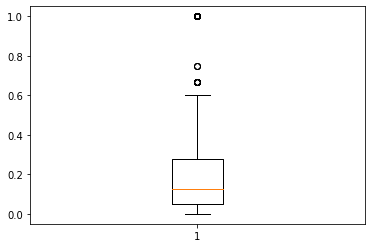

In [53]:
df_depchg = pd.read_csv('data/depchg_merge_raw.csv', low_memory=False)
df_meta = pd.read_csv('data/depchg_merge_meta.csv', low_memory=False)

df_happened = df_meta[df_meta['merge_pom_depchgs'] != 0]

total_commits = np.sum(df_meta['merge_pom_commits'])
total_depchgs = np.sum(df_meta['merge_pom_depchgs'])
avg_rate = np.mean(np.sum(df_meta['merge_pom_depchgs'])/np.sum(df_meta['merge_pom_commits']))
print(total_depchgs, total_commits, avg_rate)

import matplotlib.pyplot as plt
plt.boxplot(list(df_happened['merge_pom_depchgs']/df_happened['merge_pom_commits']))

In [76]:
df_happened['rate'] = df_happened['merge_pom_depchgs']/df_happened['merge_pom_commits']
df_happened = df_happened.sort_values('rate', ascending=False)
df_happened.head()

<ipython-input-76-8de95c1f70c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_happened['rate'] = df_happened['merge_pom_depchgs']/df_happened['merge_pom_commits']


,merge_pom_commits,merge_pom_depchgs,nameWithOwner,adds,blob,commit,parentblobs,rems,rate
12834,2.0,2.0,forge/plugin-hibernate-tools,NaN,NaN,NaN,NaN,NaN,1.0
17678,1.0,1.0,bennidi/mbassador-spring,NaN,NaN,NaN,NaN,NaN,1.0
14442,1.0,1.0,bpodgursky/uncharted,NaN,NaN,NaN,NaN,NaN,1.0
17773,2.0,2.0,Vijay2win/flume-cassandra-sink,NaN,NaN,NaN,NaN,NaN,1.0
17763,1.0,1.0,jfillo/spring-websocket-chatroom-angularjs,NaN,NaN,NaN,NaN,NaN,1.0


In [60]:
# false positives may occur
# Apom [Bpom] -> ABPom ?

def find_pom_inconsistency(df_depchg: pd.DataFrame):

    df_exceptions = pd.DataFrame()

    for idx, row in tqdm(df_depchg.iterrows(), total=len(df_happened)): 
        dg, comdf = analysis_commits(row['nameWithOwner'])
        pom_commits = list(comdf[comdf['is_pom'] == True].index)
        p = get_nearset_pom_commit_all(dg, pom_commits)

        parent_poms = set()
        merge_poms = set()

        for parent in comdf.at[row['commit'], 'parents']:
            nearest_pom = p[parent]
            for diff in comdf.at[nearest_pom, 'diffs']:
                if re.match(diff['filename'], r'pom.xml$'):
                    parent_poms.add(diff['filename'])

        for diff in comdf.at[row['commit'], 'diffs']:
            if re.match(diff['filename'], r'pom.xml$'):
                merge_poms.add(diff['filename'])

        if parent_poms != merge_poms:
            print(parent_poms, merge_poms)
            df_exceptions = df_exceptions.append(row)

    return df_exceptions

find_pom_inconsistency(df_depchg[:10]).to_csv('cache/temp_inconsistencies.csv', index=False)
pd.read_csv('cache/temp_inconsistencies.csv')

  0%|          | 0/2074 [00:00<?, ?it/s]

EmptyDataError: No columns to parse from file

In [ ]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

res_df = parallelize_dataframe(df_depchg, find_pom_inconsistency)
res_df.to_csv('cache/pom_inconsistencies.csv', index=False)
res_df

In [91]:
df_test = df_depchg[df_depchg['nameWithOwner'] == 'bennidi/mbassador-spring']
df_test.reset_index(drop=True, inplace=True)
df_test.at[0, 'commit'],df_test.at[0, 'blob'], df_test.at[0, 'parentblobs']

('e6a1384bb3aefebdb1b70fefec4d6e0915503244',
 "['c5f88828ad35b6320a40c4e82224b3e30223cf17']",
 "{'5c176a209c7d9d44ab614921a6dc067ed2d7d0b5': ['f56c431c0dde764aa1f1c165b429d661336f732d'], 'e02e945683cdf6a0587d49232da70504faebc22b': ['f56c431c0dde764aa1f1c165b429d661336f732d']}")

In [92]:
db.wocCommit.find_one({"_id":"e6a1384bb3aefebdb1b70fefec4d6e0915503244"})

{'_id': 'e6a1384bb3aefebdb1b70fefec4d6e0915503244',
 'diffs': [{'newBlob': 'c5f88828ad35b6320a40c4e82224b3e30223cf17',
   'oldBlob': '97d811eedd600232f52a9473fba0ed5e3c14a282',
   'filename': 'pom.xml'},
  {'newBlob': '459a1aa7dd778f92ecbb819c750a0c1ecc303c05',
   'oldBlob': '3bf80653a7062446d0010514270e801b6d75866b',
   'filename': 'src/test/java/org/mbassy/test/scenario/BaseTest.java'}],
 '_class': 'edu.pku.migrationhelper.data.woc.WocCommit',
 'timestamp': datetime.datetime(2015, 12, 27, 13, 57, 2),
 'parents': ['5c176a209c7d9d44ab614921a6dc067ed2d7d0b5',
  'e02e945683cdf6a0587d49232da70504faebc22b'],
 'error': False,
 'message': 'Merge pull request #8 from eccosolutions/pull-build-nicely\n\nSmall changes to build nicely with Maven and Eclipse too'}

In [93]:
db.wocCommit.find_one({"_id":"5c176a209c7d9d44ab614921a6dc067ed2d7d0b5"})

{'_id': '5c176a209c7d9d44ab614921a6dc067ed2d7d0b5',
 'diffs': [{'newBlob': 'e39a0e1696a4d8ed35836e8cb2712726db71a01d',
   'oldBlob': 'f8d527b3717f6692b519d183fd4d9ab6fcccfbac',
   'filename': 'src/main/java/org/mbassy/spring/TransactionAwareMessageBus.java'},
  {'newBlob': '50610ee432858af7ee06ff21c9d7aebe74186f92',
   'oldBlob': '852bced5d53bfd42965fcf50f556bc0468578891',
   'filename': 'src/test/java/org/mbassy/test/Example.java'},
  {'newBlob': '8245edc1224087df3f840853ba68426d2bad8ad2',
   'oldBlob': 'cef9cc3acaa4d762b4da14ae4f1f0de053ddb96f',
   'filename': 'src/test/java/org/mbassy/test/messages/ListenerTrackingMessage.java'}],
 '_class': 'edu.pku.migrationhelper.data.woc.WocCommit',
 'timestamp': datetime.datetime(2015, 10, 15, 17, 58, 8),
 'parents': ['29b6db4e27ff7e763b88a857f7c3a8c36f028147'],
 'error': False,
 'message': 'Small refactorings with minor API changes. Increased test coverage\n'}

In [94]:
db.wocCommit.find_one({"_id":"e02e945683cdf6a0587d49232da70504faebc22b"})

{'_id': 'e02e945683cdf6a0587d49232da70504faebc22b',
 'diffs': [],
 '_class': 'edu.pku.migrationhelper.data.woc.WocCommit',
 'timestamp': datetime.datetime(2015, 12, 23, 15, 1, 58),
 'parents': ['b90b5326bda5e5dce717bcd04cca16aa32549776'],
 'error': False,
 'message': 'Add versions for compiler and surefire plugins to stop Maven complaining\n'}

In [99]:
dg2, comdf = analysis_commits('bennidi/mbassador-spring')
comdf.loc['e02e945683cdf6a0587d49232da70504faebc22b']

diffs                                                       []
_class              edu.pku.migrationhelper.data.woc.WocCommit
timestamp                            2015-12-23 15:01:58+00:00
parents             [b90b5326bda5e5dce717bcd04cca16aa32549776]
error                                                    False
message      Add versions for compiler and surefire plugins...
is_pom                                                   False
is_merge                                                 False
Name: e02e945683cdf6a0587d49232da70504faebc22b, dtype: object

In [105]:
pom_commits = list(comdf[comdf['is_pom'] == True].index)
p = get_nearset_pom_commit_all(dg2, pom_commits)
p['5c176a209c7d9d44ab614921a6dc067ed2d7d0b5'], p['e02e945683cdf6a0587d49232da70504faebc22b']

('df42da9933104c0310176ab505446d80372780b5',
 'df42da9933104c0310176ab505446d80372780b5')

In [108]:
comdf.loc['df42da9933104c0310176ab505446d80372780b5']['diffs']

[{'newBlob': 'f56c431c0dde764aa1f1c165b429d661336f732d',
  'oldBlob': 'dd3f6a35052655a9d85f55e8d322085edb3f69cb',
  'filename': 'pom.xml'},
 {'newBlob': 'c3dc8d3e4ee650fa68fdc5e408e204de9f8490f2',
  'oldBlob': '3467bd642fb8a0cba1bb5289945c37ceba661f7c',
  'filename': 'src/main/java/org/mbassy/spring/BeanEventingProcessor.java'},
 {'newBlob': '1a23e41257ec4ad9cd9977163655fde5bf517f04',
  'oldBlob': '9282946c0e272d2f9b912274073d5047c14af8fd',
  'filename': 'src/main/java/org/mbassy/spring/ITransactionalPostCommand.java'},
 {'newBlob': '1f30366d4b7d8946cbaf3a831ba39618031306ad',
  'oldBlob': '749400ff96b12c934620675bcde2ec78e6a8bfa9',
  'filename': 'src/main/java/org/mbassy/spring/Transaction.java'},
 {'newBlob': '7e0a8d2fc8a009b2bc56350b41639026061f2aef',
  'oldBlob': 'c52a2583f2ddb35d392e91987a9f3eda149d2519',
  'filename': 'src/main/java/org/mbassy/spring/TransactionalEventBus.java'},
 {'newBlob': 'cc85fc1f8f8e9349001ca1de9eeafba2b6e83d64',
  'oldBlob': '',
  'filename': 'src/test/java

In [109]:
db.wocPomBlob.find_one({"_id":"f56c431c0dde764aa1f1c165b429d661336f732d"})

{'_id': 'f56c431c0dde764aa1f1c165b429d661336f732d',
 '_class': 'edu.pku.migrationhelper.data.woc.WocPomBlob',
 'dependencies': [{'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-test'},
  {'version': '1.6.12', 'groupId': 'org.aspectj', 'artifactId': 'aspectjrt'},
  {'version': '2.0-cr-1',
   'groupId': 'org.hibernate.java-persistence',
   'artifactId': 'jpa-api'},
  {'version': '4.0.1.Final',
   'groupId': 'org.hibernate',
   'artifactId': 'hibernate-entitymanager'},
  {'version': '1.3.168', 'groupId': 'com.h2database', 'artifactId': 'h2'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-context-support'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-jdbc'},
  {'version': '1.6.12',
   'groupId': 'org.aspectj',
   'artifactId': 'aspectjweaver'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-core'},
  {'versio

In [110]:
db.wocPomBlob.find_one({"_id":"c5f88828ad35b6320a40c4e82224b3e30223cf17"})

{'_id': 'c5f88828ad35b6320a40c4e82224b3e30223cf17',
 '_class': 'edu.pku.migrationhelper.data.woc.WocPomBlob',
 'dependencies': [{'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-test'},
  {'version': '1.6.12', 'groupId': 'org.aspectj', 'artifactId': 'aspectjrt'},
  {'version': '2.0-cr-1',
   'groupId': 'org.hibernate.java-persistence',
   'artifactId': 'jpa-api'},
  {'version': '4.0.1.Final',
   'groupId': 'org.hibernate',
   'artifactId': 'hibernate-entitymanager'},
  {'version': '1.6.12',
   'groupId': 'org.aspectj',
   'artifactId': 'aspectjweaver'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-context-support'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-jdbc'},
  {'version': '1.3.168', 'groupId': 'com.h2database', 'artifactId': 'h2'},
  {'version': '3.1.0.RELEASE',
   'groupId': 'org.springframework',
   'artifactId': 'spring-core'},
  {'versio